In [60]:
import dill
with open("lcbench_known_cost_metrics_per_acq.pkl", "rb") as f:
    metrics_per_acq = dill.load(f)

In [61]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
acquisition_functions = {
        "LogEIC": "LogEIC",
        "StablePBGI(1e-3)": "PBGI(1e-3)",
        "StablePBGI(1e-4)": "PBGI(1e-4)", 
        "StablePBGI(1e-5)": "PBGI(1e-5)", 
        "LCB": "LCB",
        "TS": "TS"
    }

In [ ]:
'''
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
'''

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.4
})
print(plt.style.available)

plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    # 'xtick.rotation': 45,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.autolayout': False,  # we’ll call tight_layout() explicitly
})

In [62]:
best_acc_per_dataset = {
    'Fashion-MNIST': 90.17316017316017,
    'adult': 83.00552211950115,
    'higgs': 71.86302385956238,
    'volkert': 62.765681026866915
}

In [63]:
import numpy as np

# === User‐provided data and helper functions (assumed to exist) ===
# metrics_per_acq[d][acq_key]["estimated cumulative cost"]
# test_metrics_per_acq[d][acq_key]["final test error"]
# bench.query_best_final(dataset, "final_test_accuracy", "final_test_accuracy", 0)

# === Config ===
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
lambdas       = [1e-3, 1e-4, 1e-5]
acq_order     = ['LogEIC', 'PBGI', 'LCB', 'TS']
init          = 20

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult":         40000,
    "higgs":         40000,
    "volkert":       40000
}
cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult":         40000,
    "higgs":         80000,
    "volkert":       80000
}

# === Color and marker settings ===
color_dict = {
    'LogEIC':      'tab:blue',
    'LogEIC-med':  'tab:blue',
    'PBGI(1e-3)':  'tab:orange',
    'PBGI(1e-4)':  'tab:orange',
    'PBGI(1e-5)':  'tab:orange',
    'LCB':         'tab:purple',
    'UCB-LCB':     'tab:purple',
    'SRGap-med':   'tab:pink',
    'TS':          'tab:brown',
    'PRB':         'tab:brown',
    'GSS':         'tab:olive',
    'Convergence': 'tab:gray',
    'Hindsight':   'tab:red'
}


marker_dict = {
    '1e-3': 's',
    '1e-4': 'o',
    '1e-5': '^'
}

# === Build stopping_rules for each λ ===
stopping_rules = []
for lam in lambdas:
    lam_str   = f"1e-{int(round(-np.log10(lam)))}"  # “1e-3”, “1e-4”, “1e-5”
    fixed_acq = f"PBGI({lam_str})"
    marker    = marker_dict[lam_str]

    templates = [
        {
            'stp_key':      'PBGI',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa][f"{fa} acq"][seed][i] >=
                metrics_per_acq[d][fa]["current best observed"][seed][i - 1]
            ))
        },
        # {
        #     'stp_key':      'LogEIC',
        #     'is_hindsight': False,
        #     'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
        #         i >= init and
        #         metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= np.log(lam)
        #     ))
        # },
        {
            'stp_key':      'LogEIC-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= (
                    np.log(0.01) +
                    np.nanmedian(metrics_per_acq[d][fa]["LogEIC acq"][seed][1:21])
                )
            ))
        },
        {
            'stp_key':      'SRGap-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["exp min regret gap"][seed][i] <=
                0.1 * np.nanmedian(
                    metrics_per_acq[d][fa]["exp min regret gap"][seed][1:21]
                )
            ))
        },
        {
            'stp_key':      'UCB-LCB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["regret upper bound"][seed][i] <= 0.01
            ))
        },
        {
            'stp_key':      'PRB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["PRB"][seed][i] >= 0.95
            ))
        },
        {
            'stp_key':      'GSS',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and (
                    (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                     np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     )) == 0
                ) or (
                    ((metrics_per_acq[d][fa]["current best observed"][seed][i - 5] -
                      metrics_per_acq[d][fa]["current best observed"][seed][i]) /
                     (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                      np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     ))
                    ) <= 0.01
                )
            ))
        },
        {
            'stp_key':      'Convergence',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["current best observed"][seed][i] ==
                metrics_per_acq[d][fa]["current best observed"][seed][i - 5]
            ))
        },
        {
            'stp_key':      'Hindsight',
            'is_hindsight': True,
            'condition_fn': None
        }
    ]

    for temp in templates:
        rule = {
            'acq_key':      fixed_acq,
            'stp_key':      temp['stp_key'],
            'is_hindsight': temp['is_hindsight'],
            'marker':       marker,
            'color':        color_dict.get(temp['stp_key'], color_dict[fixed_acq]),
            'label':        'PBGI/LogEIC' if temp['stp_key'] == 'PBGI' else temp['stp_key']
        }
        if temp['condition_fn'] is not None:
            rule['condition_fn'] = temp['condition_fn']
        stopping_rules.append(rule)

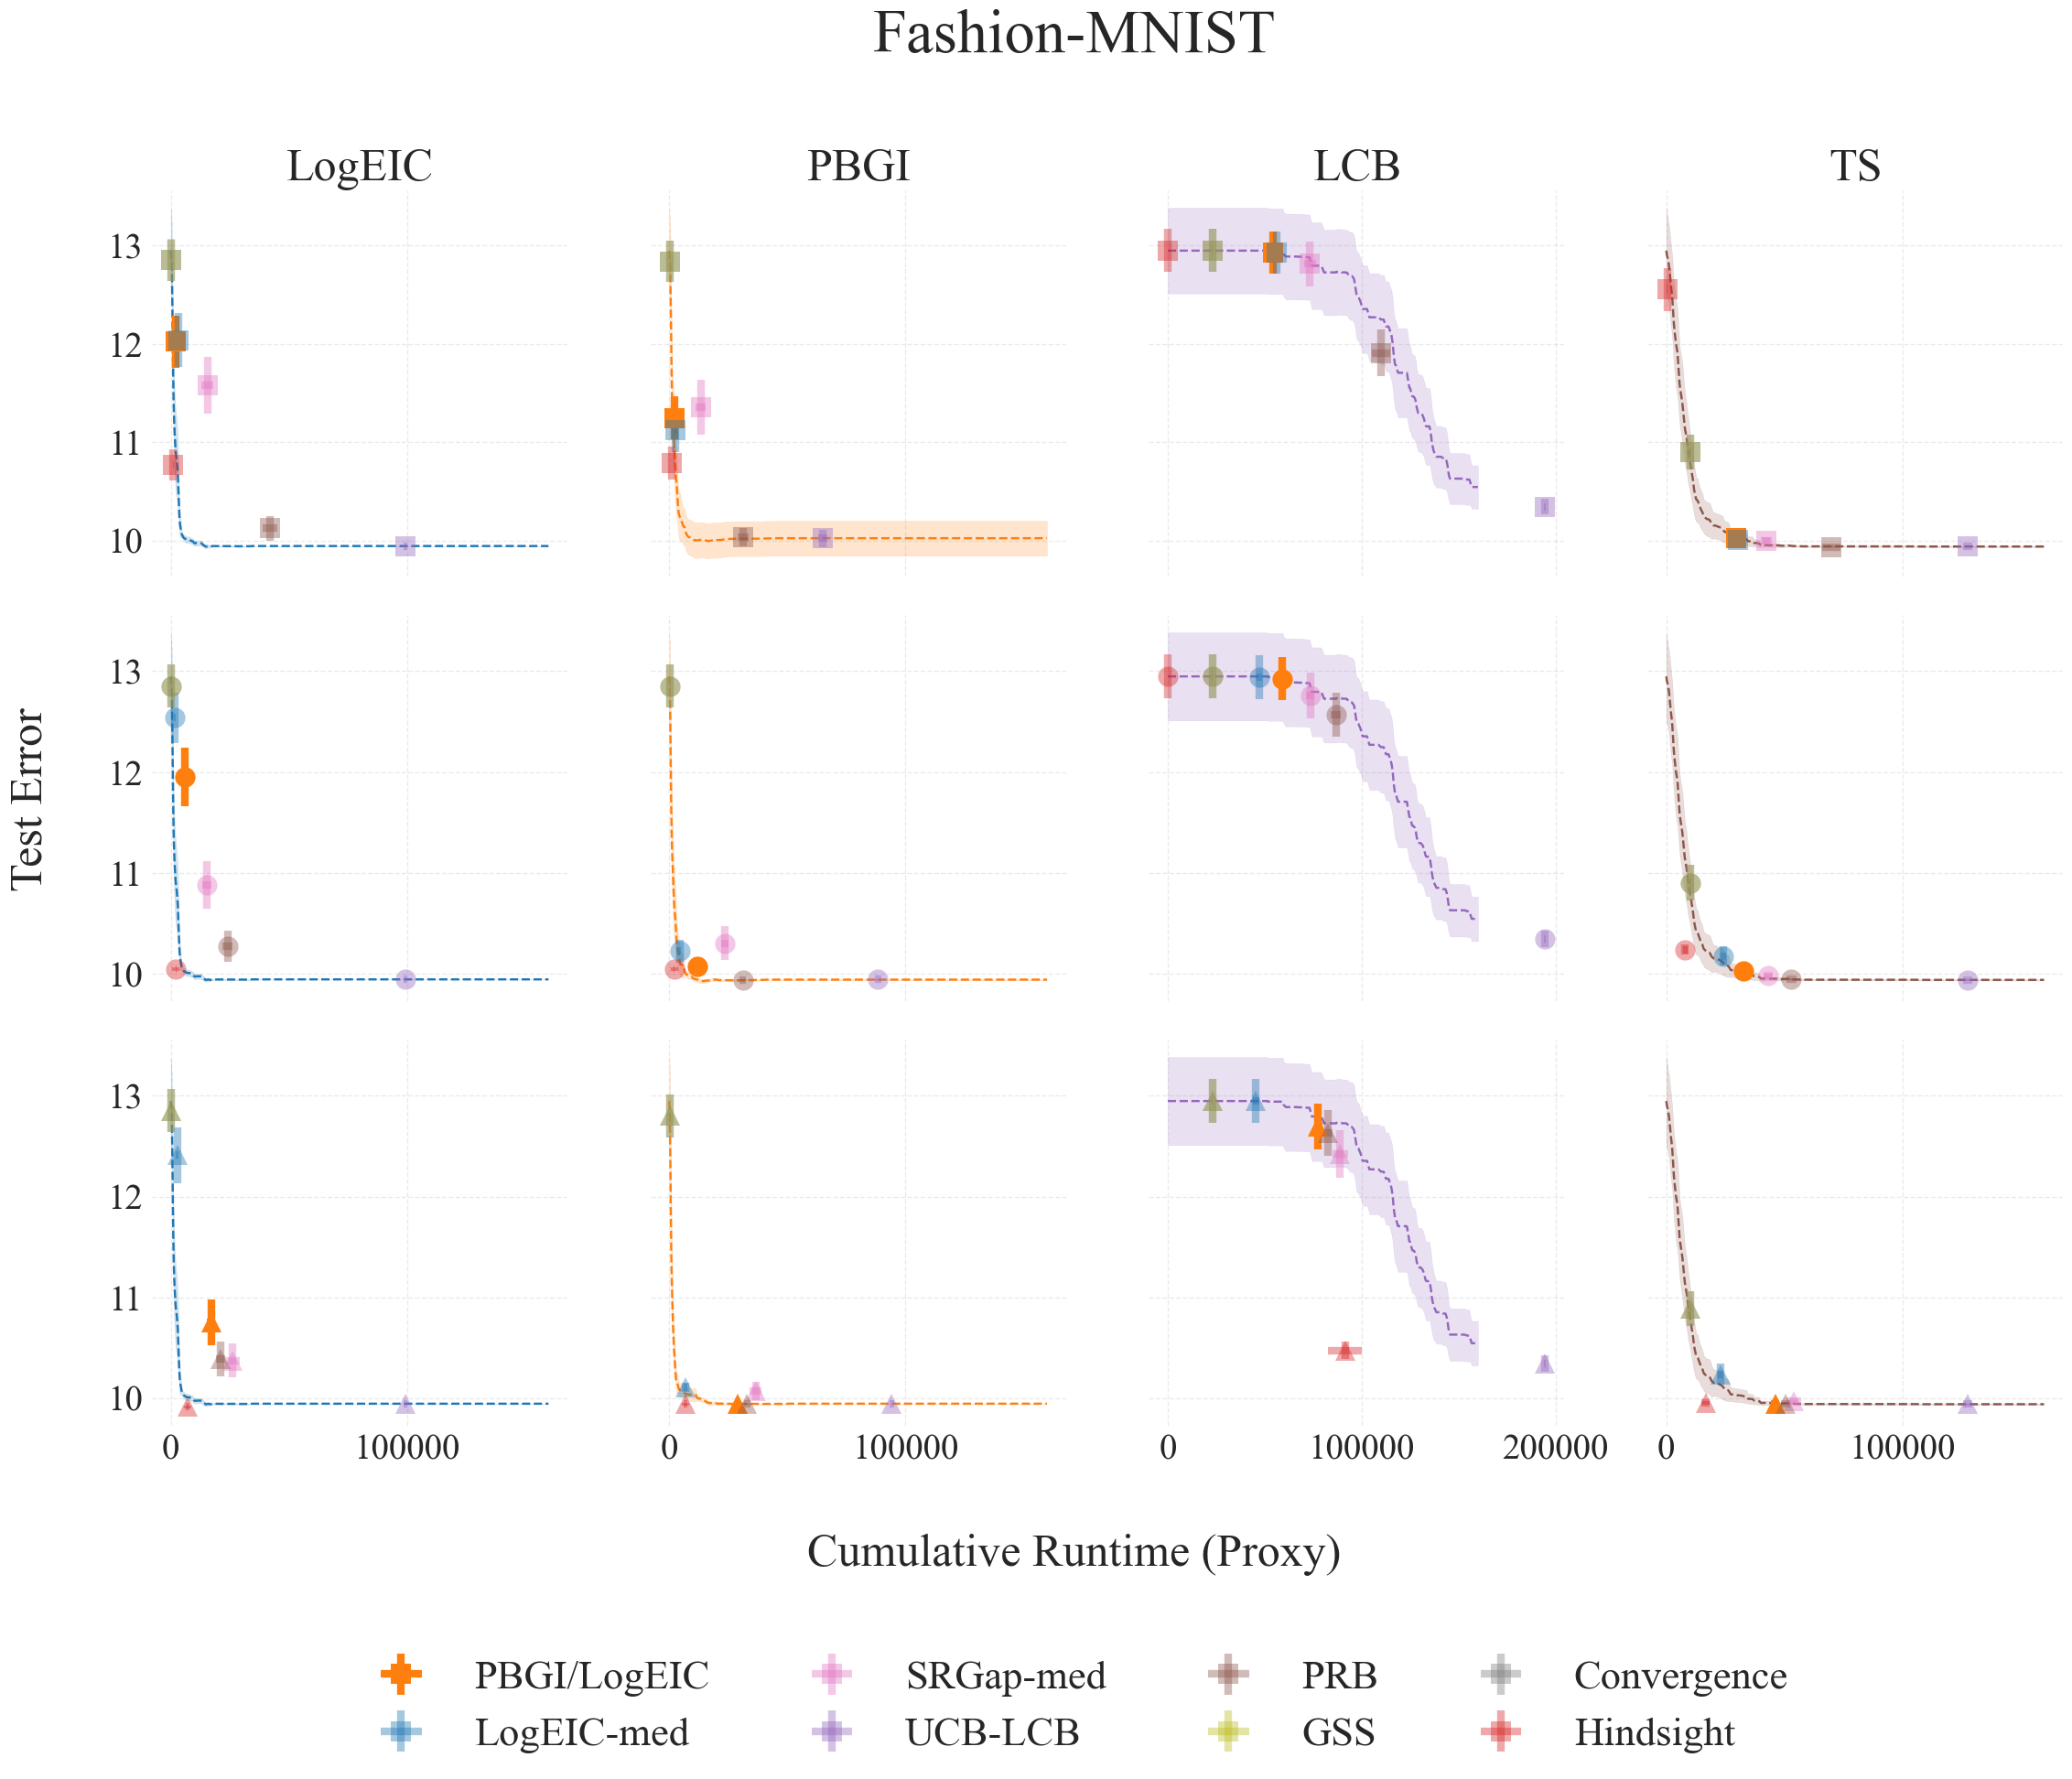

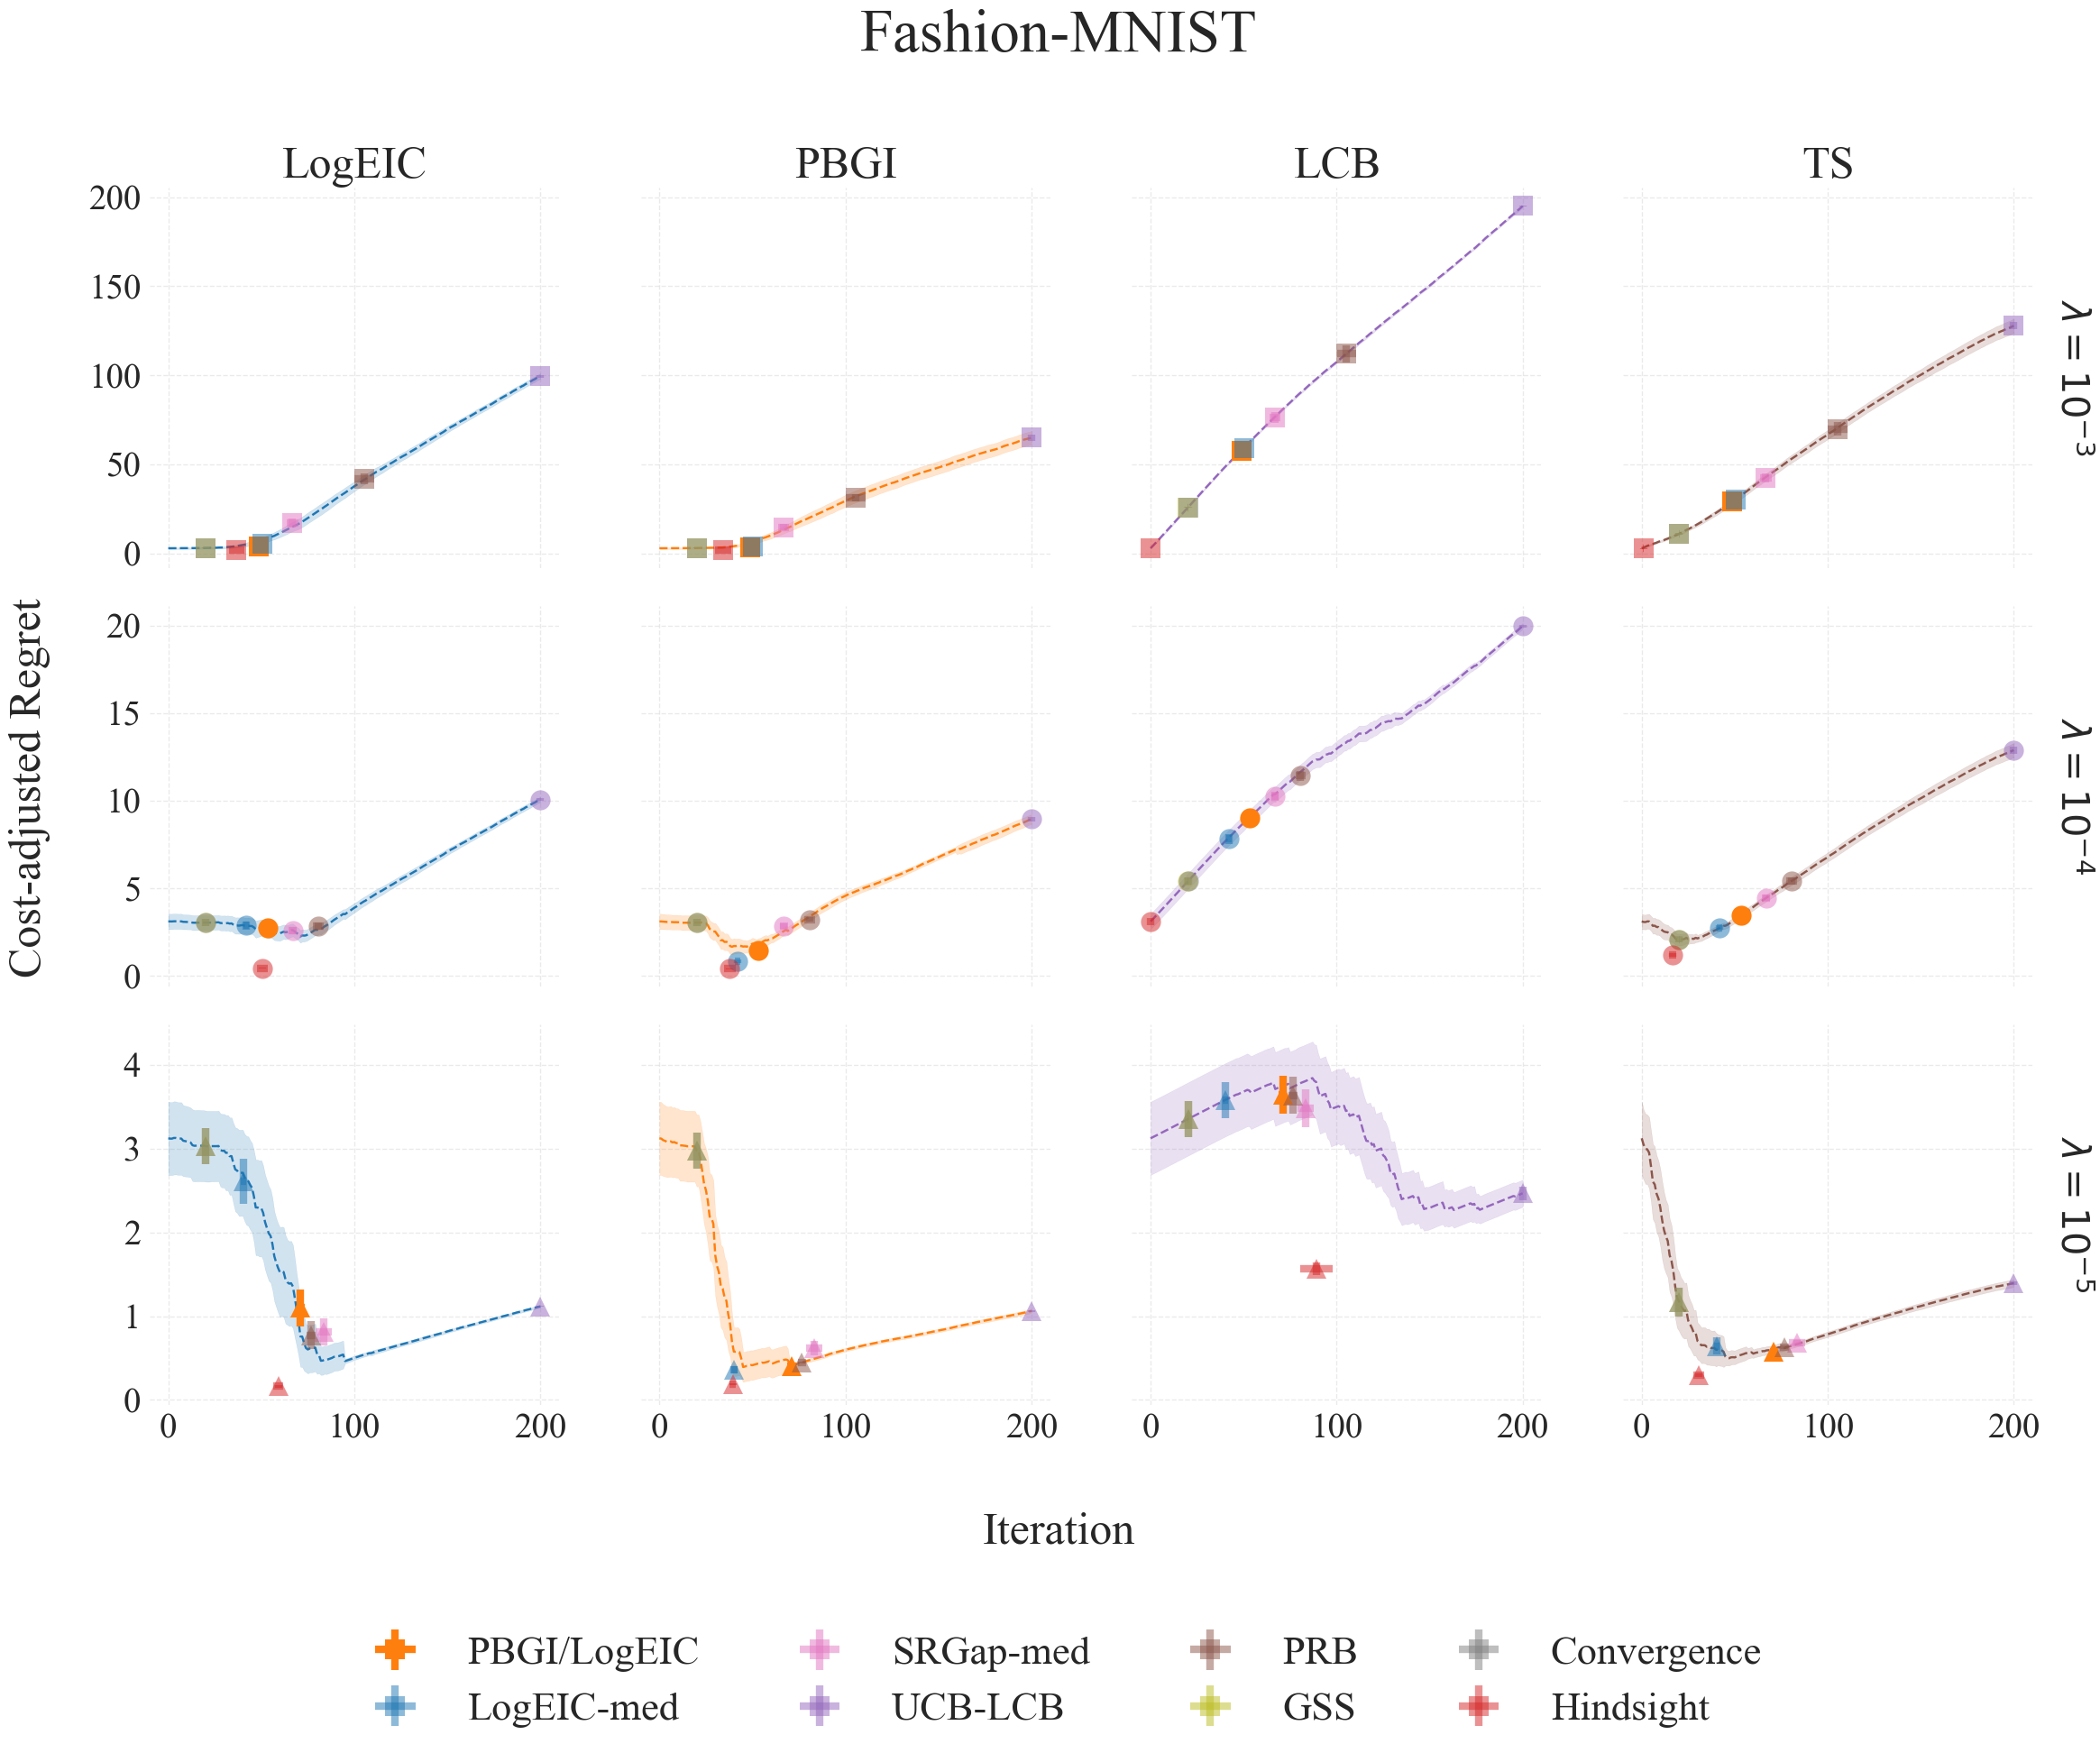

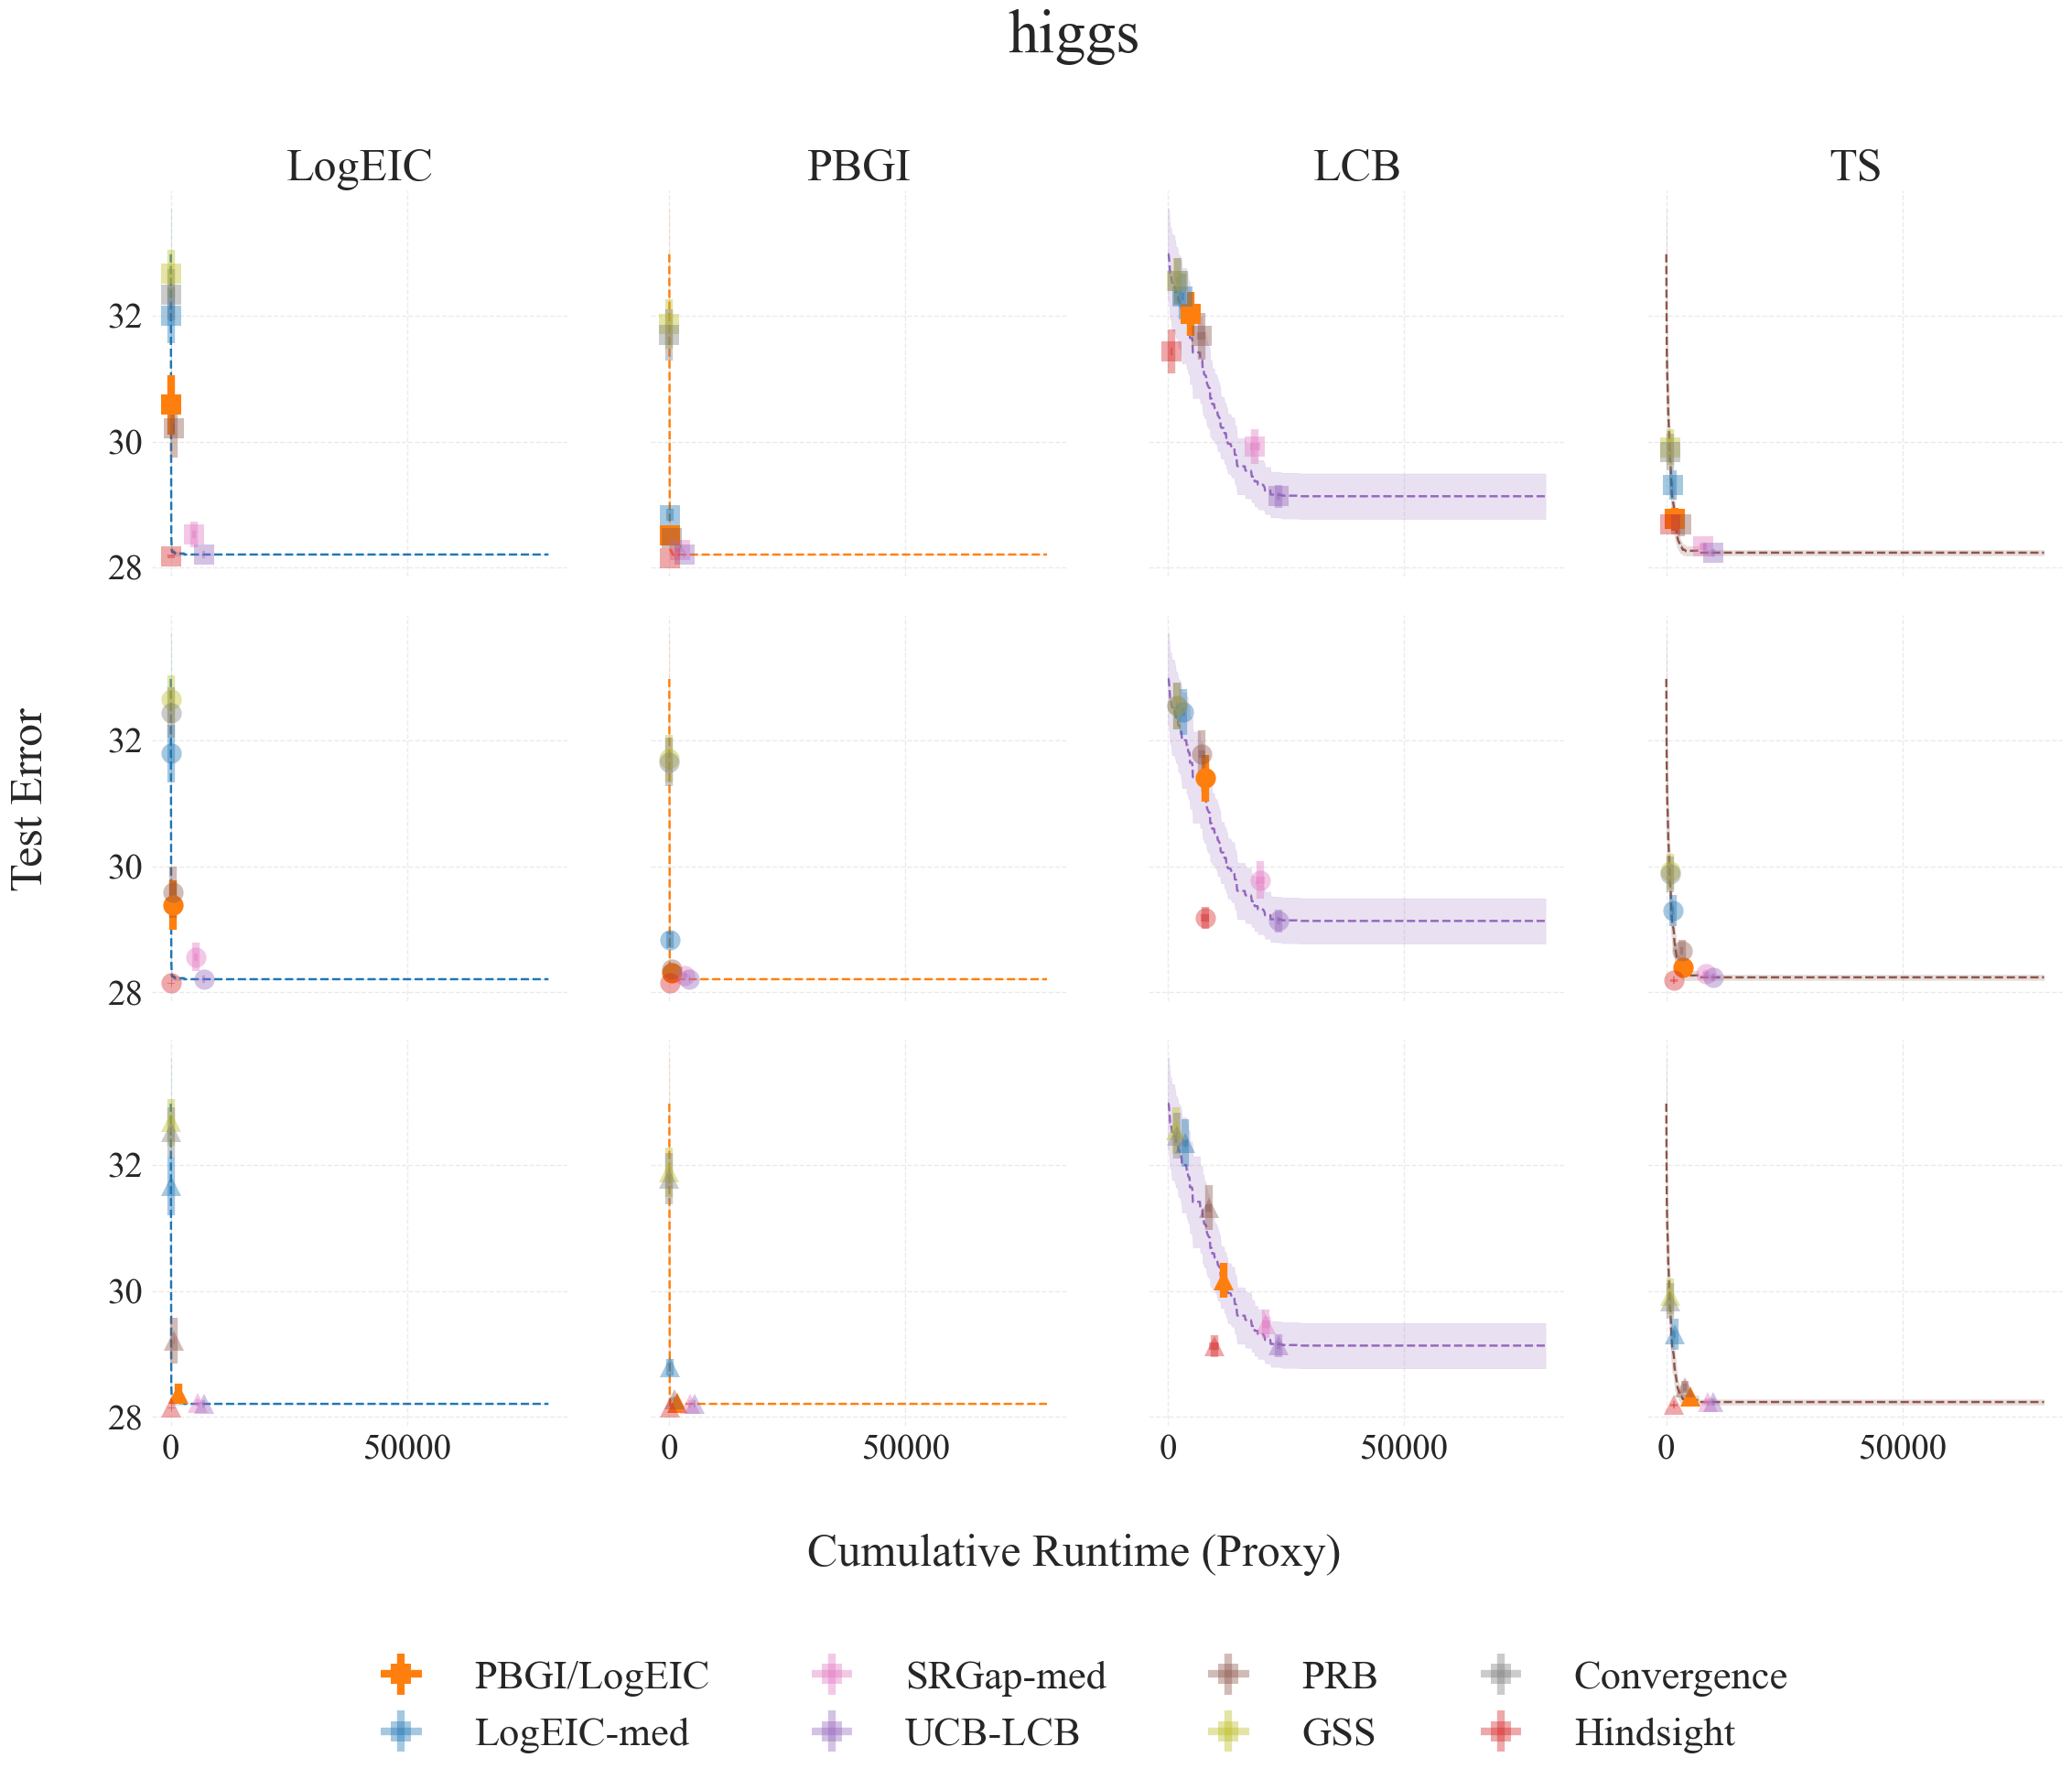

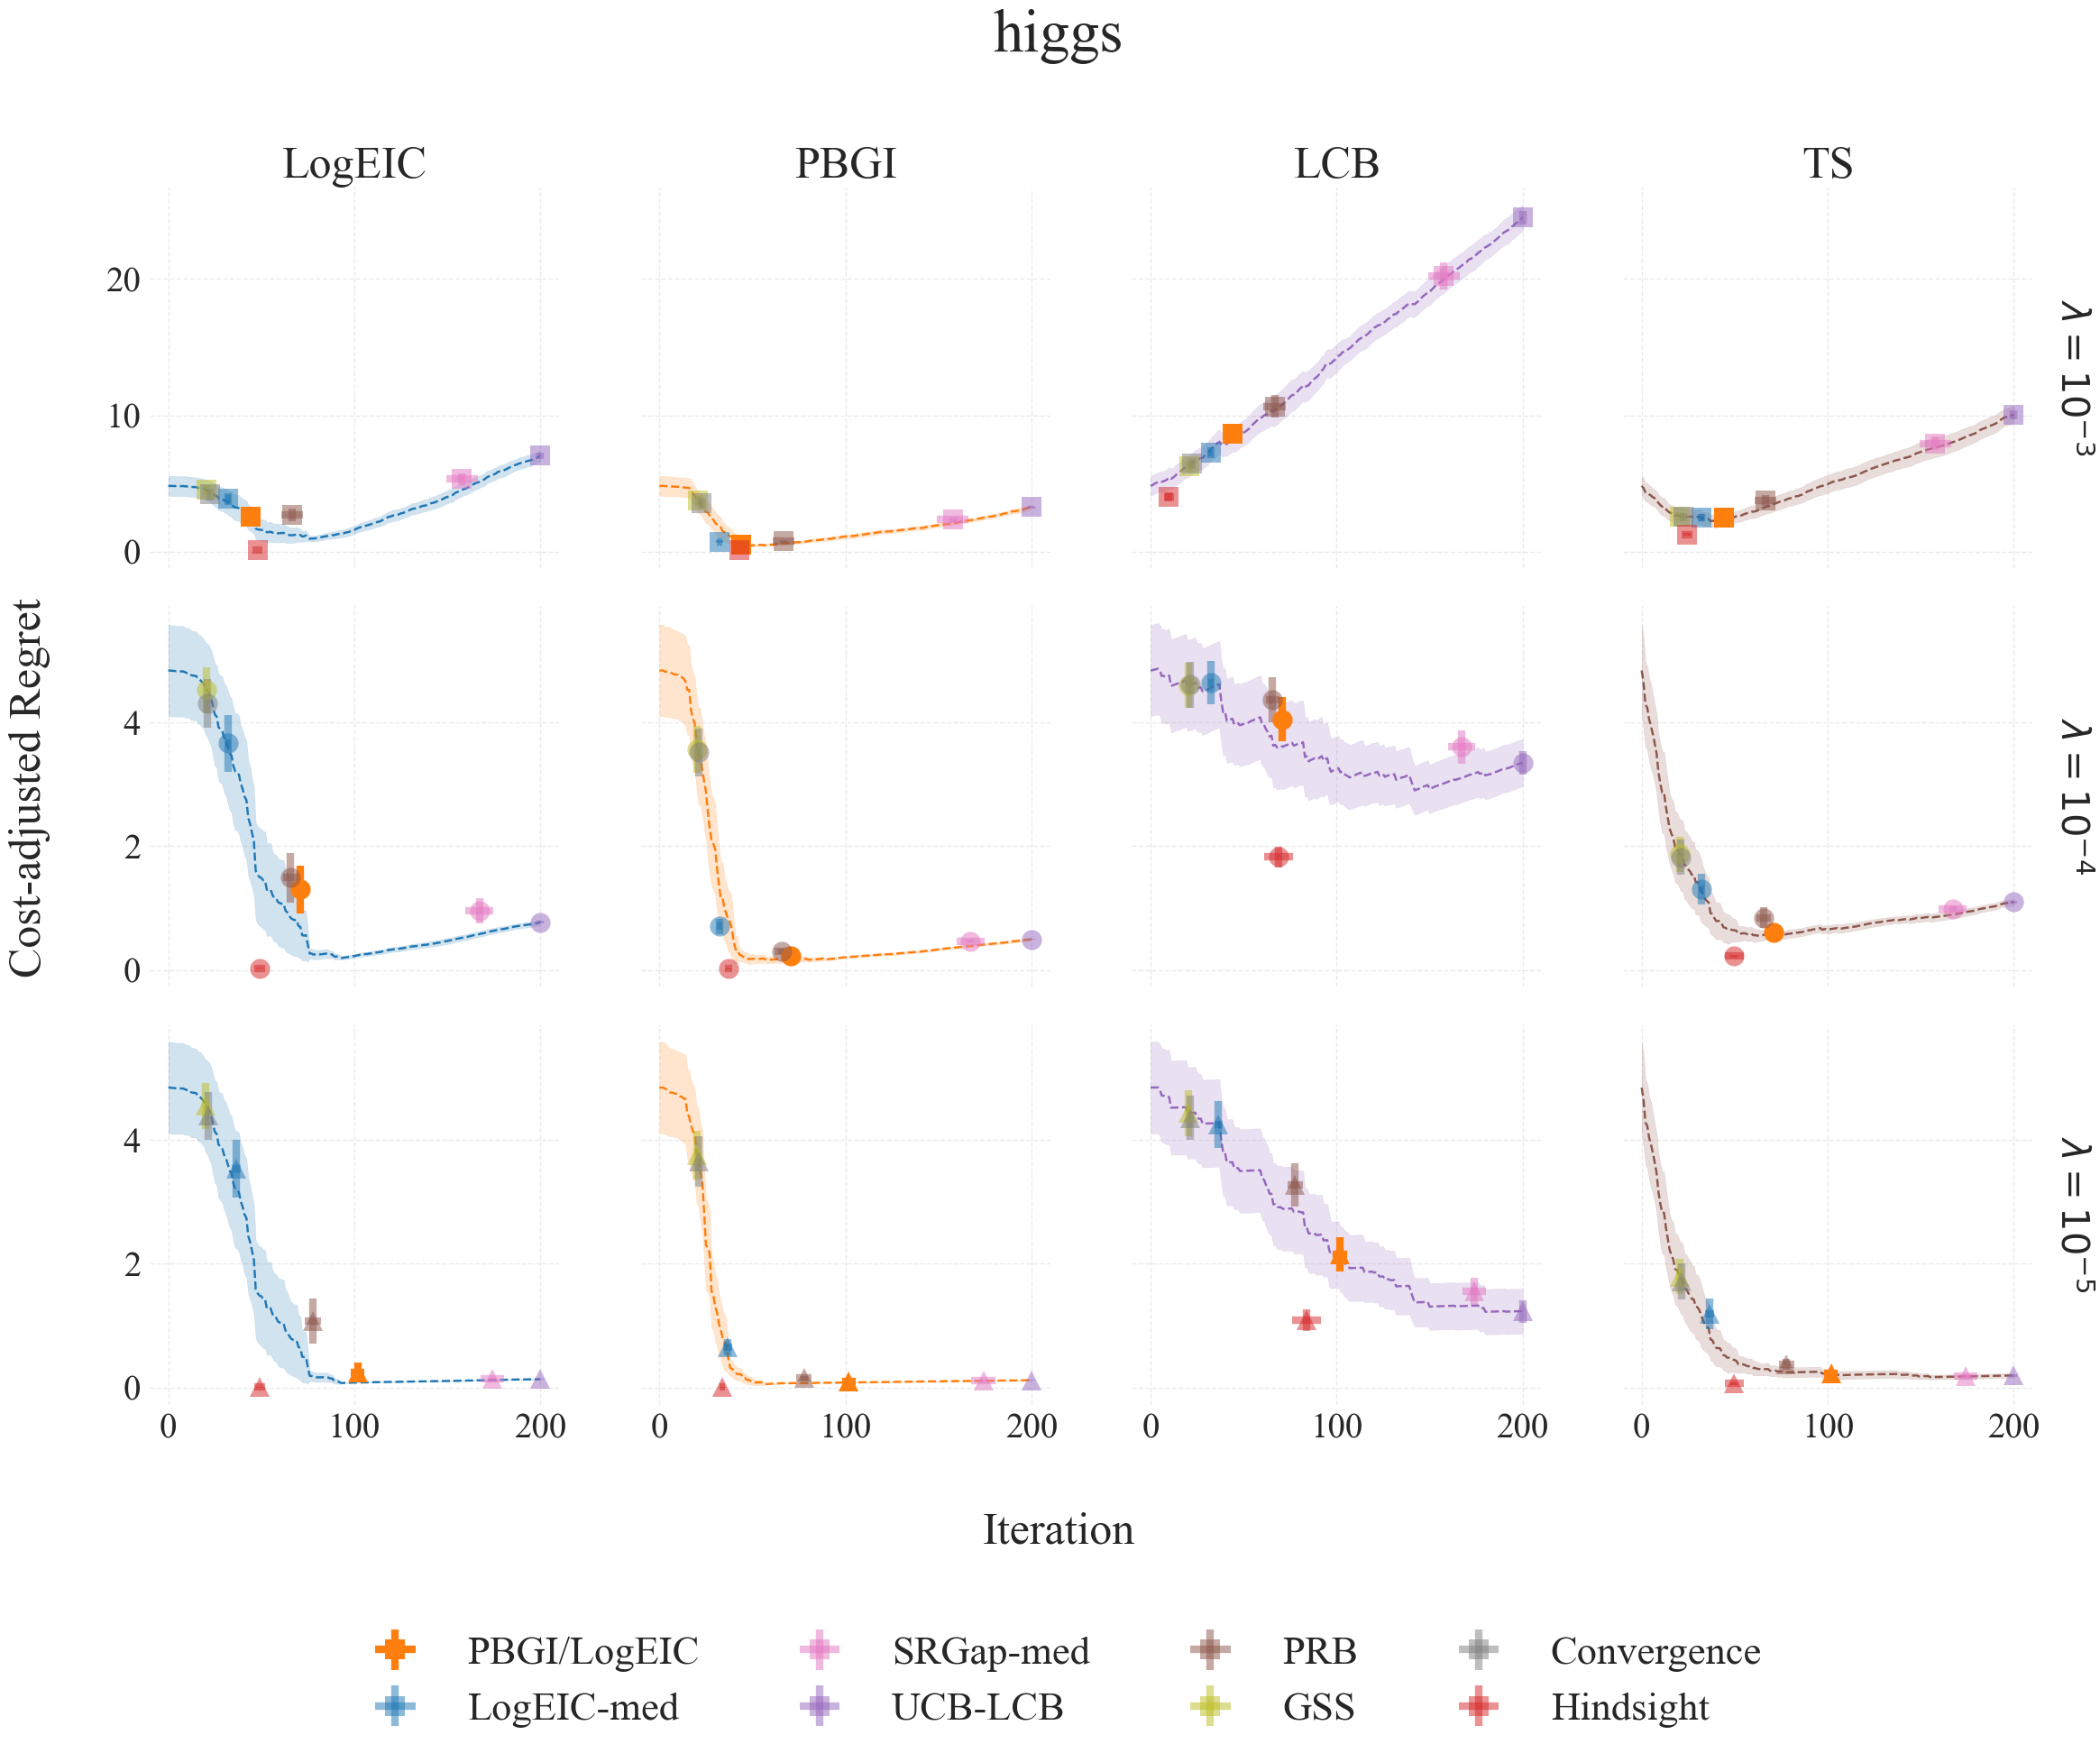

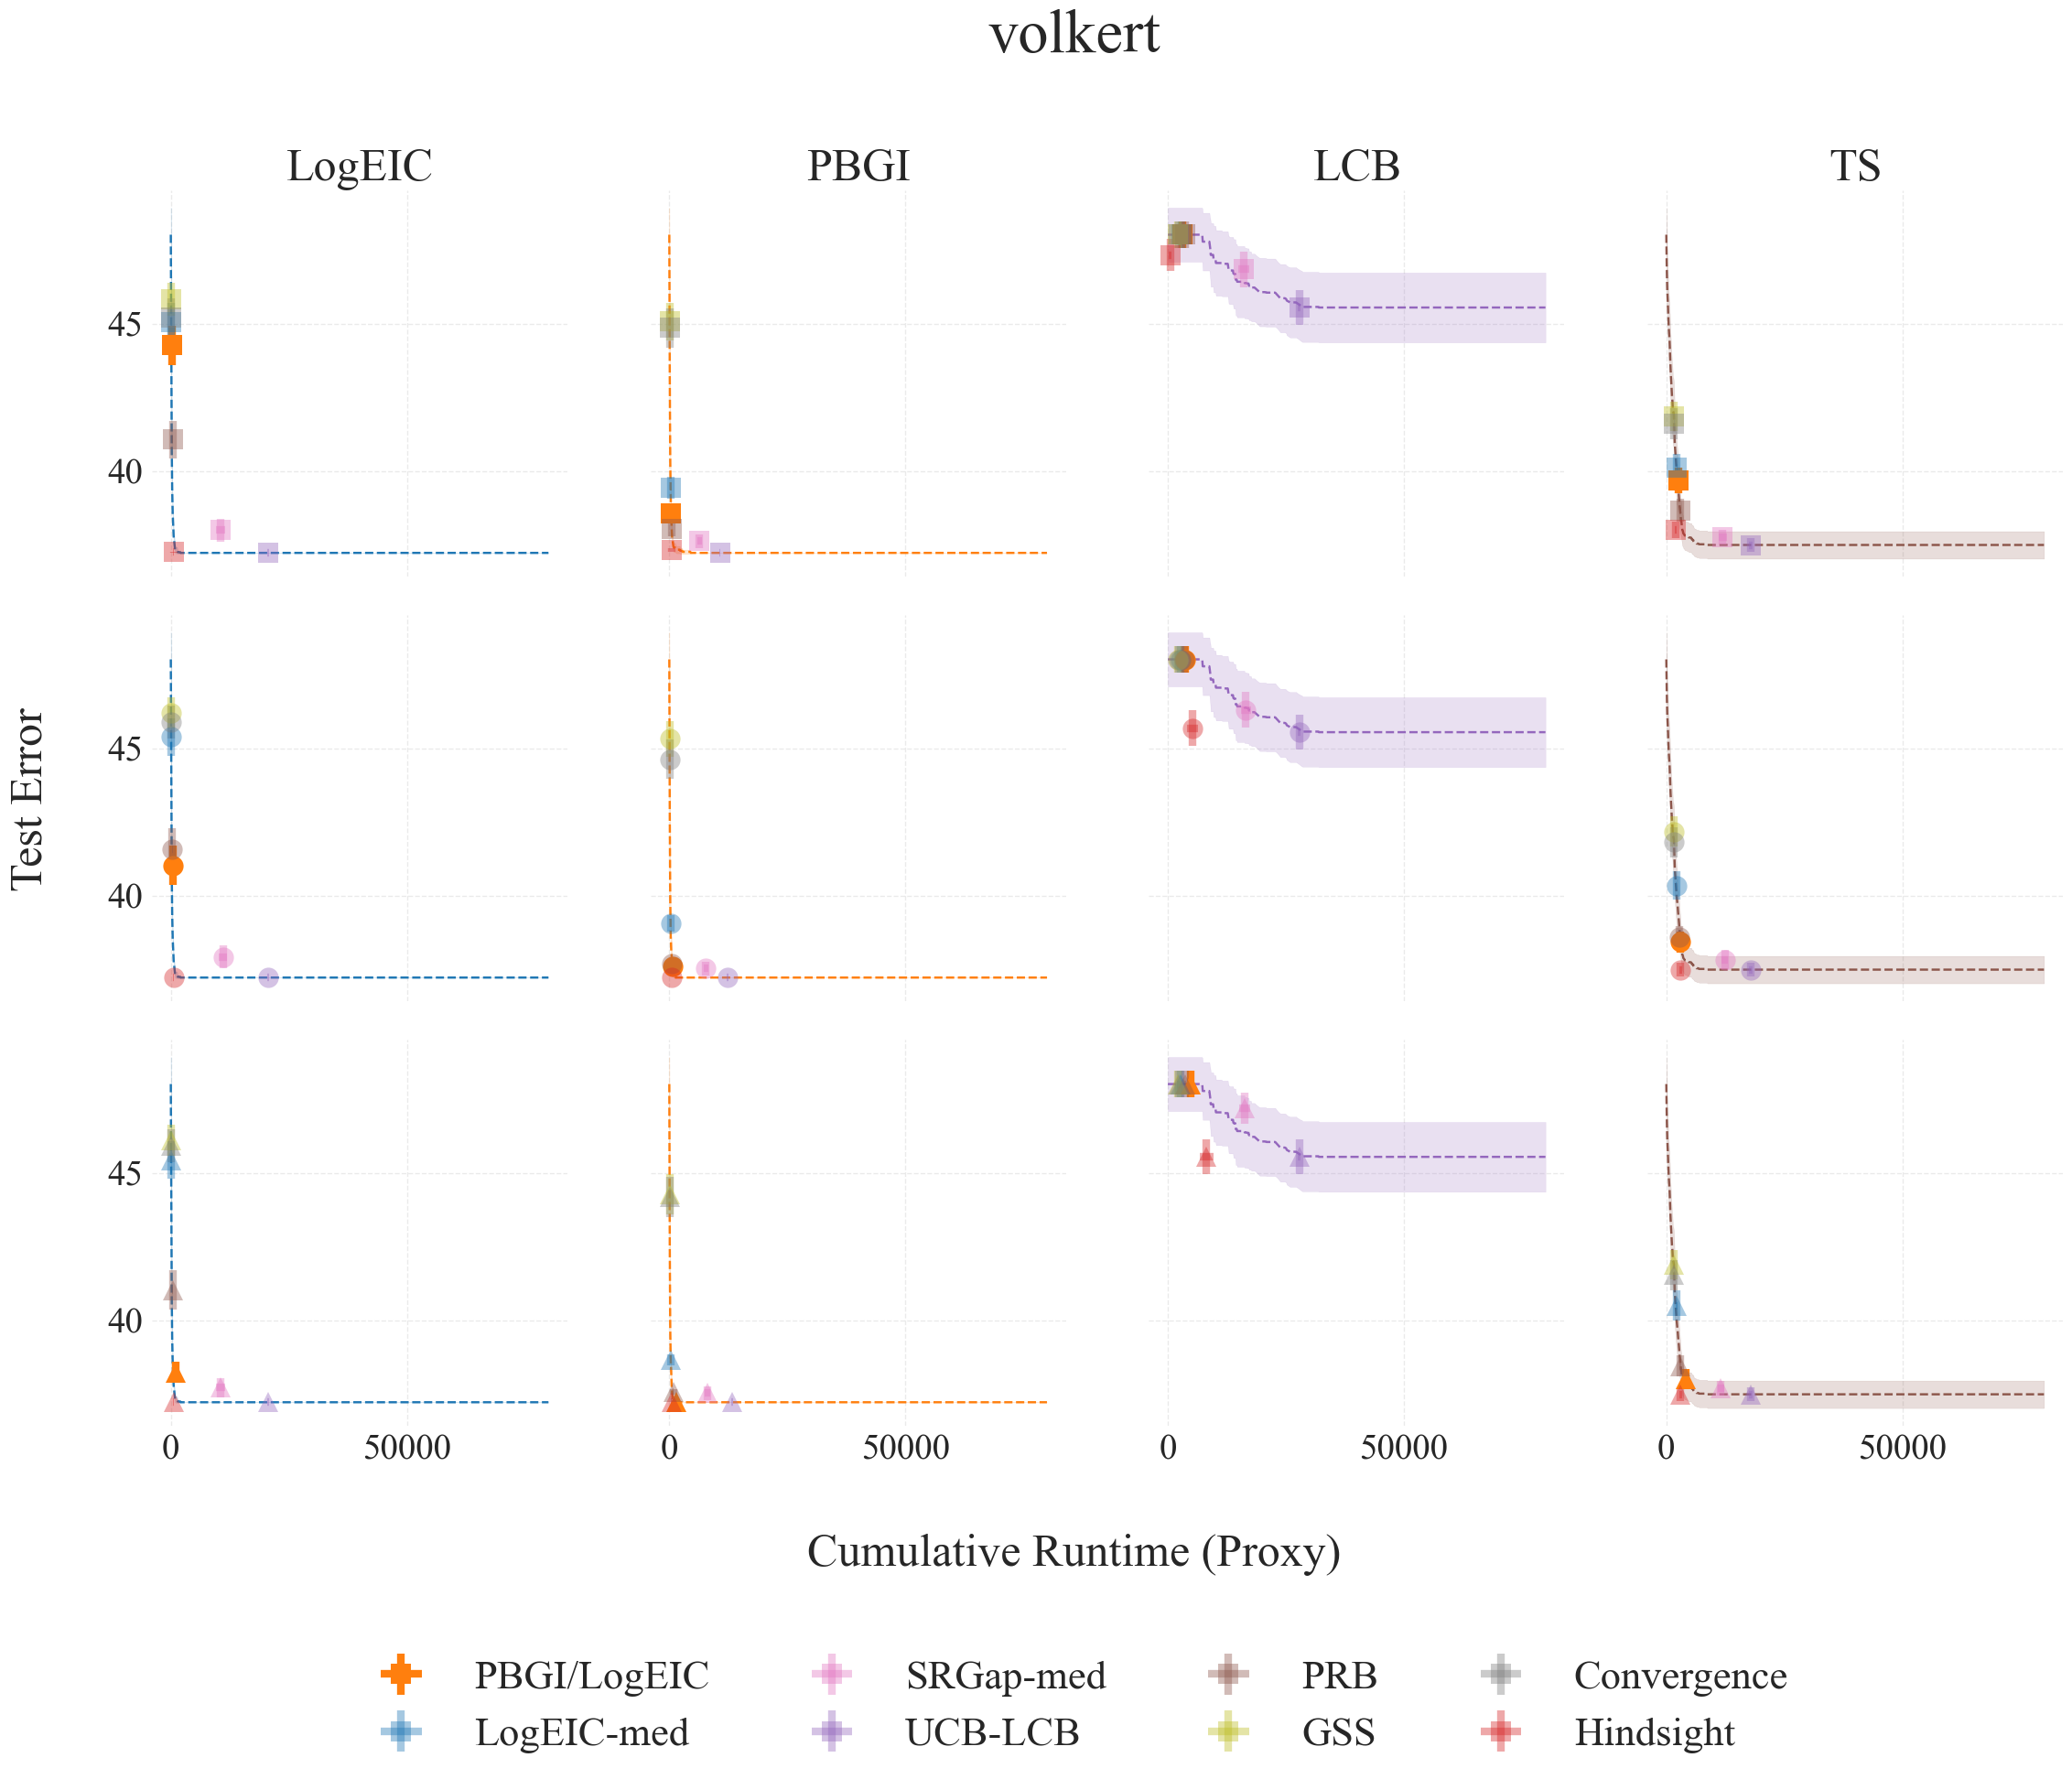

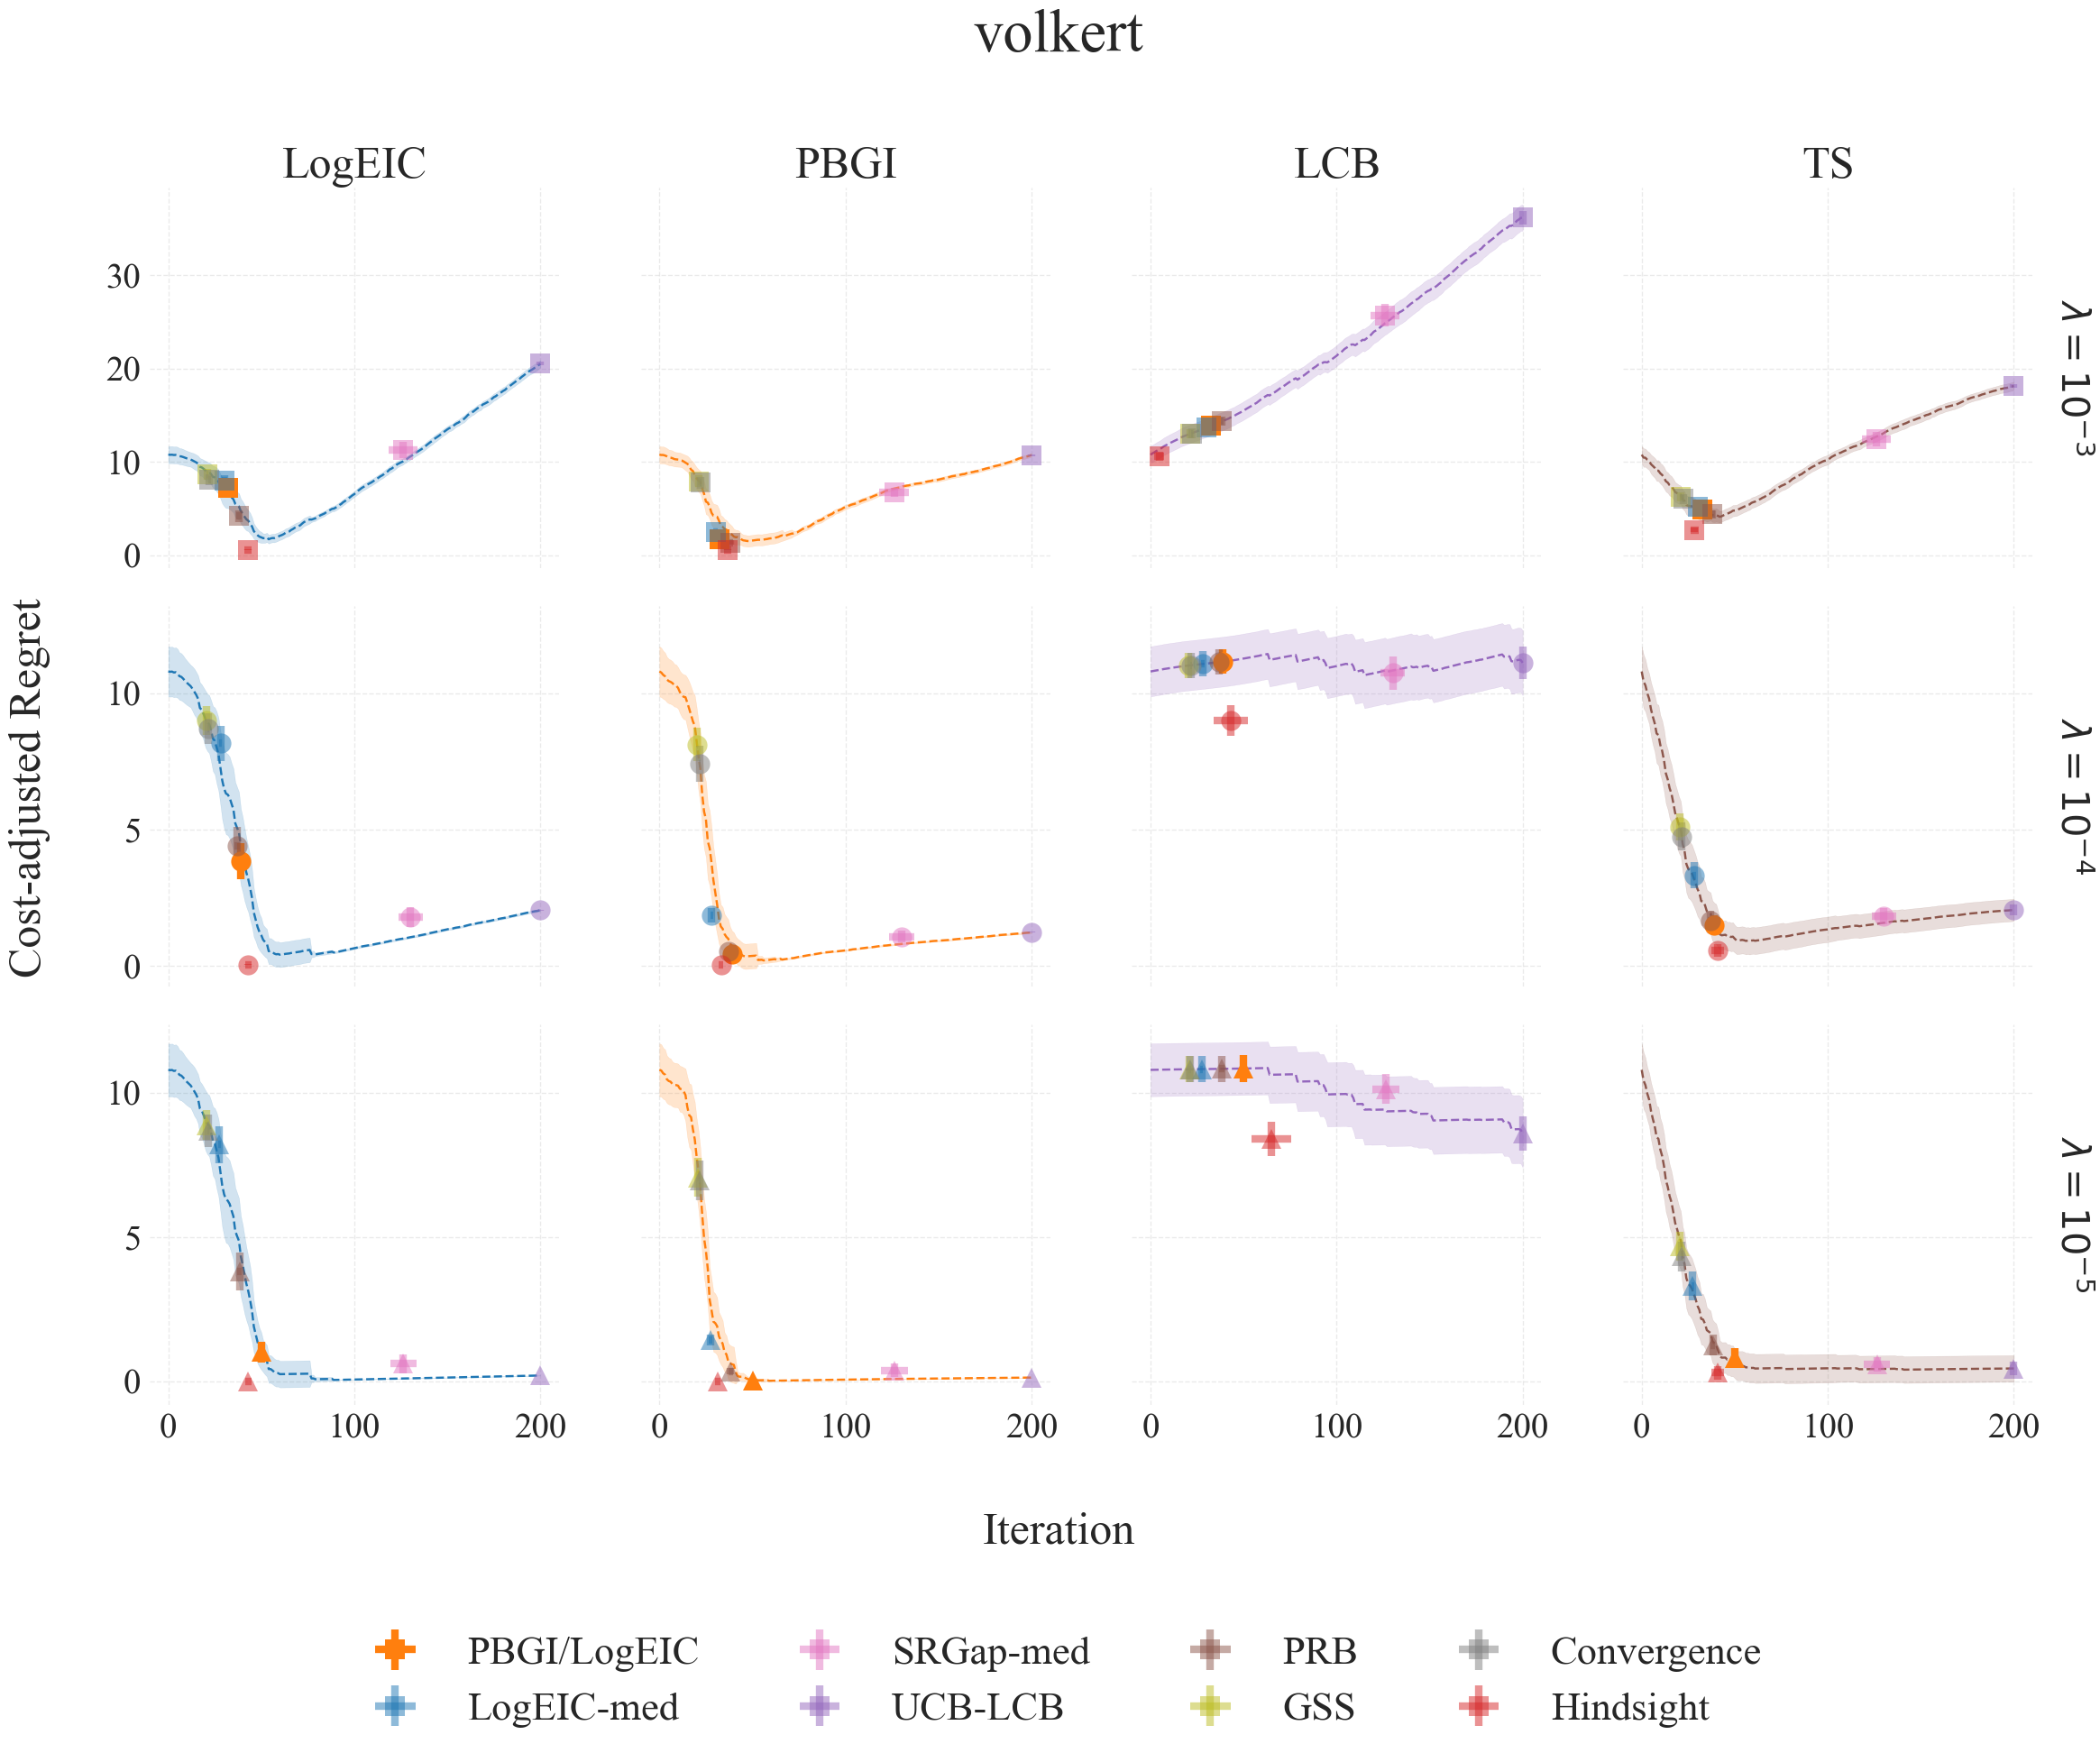

In [72]:
# === Plotting ===
for d in dataset_names:
    best_acc   = best_acc_per_dataset[d]
    best_error = 100. - best_acc

    # === 1) Test error vs estimated cumulative cost ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey="row")
    fig.suptitle(f"{d}", fontsize=48)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            # === Mean test error curve ===
            cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
            curves = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                c = np.array(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed])
                e = np.array(metrics_per_acq[d][fixed_acq]["final test error"][seed])
                idx = np.argsort(c)
                curves.append(np.interp(cost_grid, c[idx], e[idx]))
            curves = np.vstack(curves)
            mean_c = curves.mean(axis=0)
            sem_c  = curves.std(axis=0) / np.sqrt(curves.shape[0])

            ax.plot(cost_grid, mean_c, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(cost_grid, mean_c - 2 * sem_c, mean_c + 2 * sem_c, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_costs = []
                for seed in range(curves.shape[0]):
                    errs = metrics_per_acq[d][fixed_acq]["final test error"][seed]
                    costs = metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed]
                    if rule['is_hindsight']:
                        regs = np.array(errs) - best_error + lam * np.array(costs)
                        idx = np.argmin(regs)
                    else:
                        idx = next((k for k in range(init, len(errs)) if rule['condition_fn'](k, seed, d)), len(errs) - 1)
                    stop_vals.append(errs[idx])
                    stop_costs.append(costs[idx])

                mx = np.mean(stop_costs)
                my = np.mean(stop_vals)
                sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                alpha = 1.0 if rule['stp_key'] == 'PBGI' else 0.4
                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=16,
                            linewidth=6,
                            color=rule['color'],
                            capsize=6,
                            alpha=alpha,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=36)  # only first row
            ax.tick_params(axis='both', which='major', labelsize=28)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.12, top=0.87, hspace=0.1)

    fig.text(0.5, 0.035, 'Cumulative Runtime (Proxy)', ha='center', fontsize=36)
    fig.text(0.015, 0.5, 'Test Error', va='center', rotation='vertical', fontsize=36)

    # Two-row legend
    from math import ceil
    handles, labels = axes[0, 0].get_legend_handles_labels()
    half = ceil(len(handles) / 2)
    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.0),
        ncol=half,
        fontsize=32,
        frameon=False
    )

    # === 2) Regret + λ·cost vs iteration ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey='row')
    fig.suptitle(f"{d}", fontsize=48)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            regs_all = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                errs = np.array(metrics_per_acq[d][fixed_acq]["final test error"][seed])
                costs = np.array(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed])
                regs_all.append((errs - best_error) + lam * costs)
            regs_all = np.vstack(regs_all)
            mean_r = regs_all.mean(axis=0)
            sem_r  = regs_all.std(axis=0) / np.sqrt(regs_all.shape[0])
            iters  = np.arange(mean_r.shape[0])

            ax.plot(iters, mean_r, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(iters, mean_r - 2 * sem_r, mean_r + 2 * sem_r, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_iters = []
                for seed in range(regs_all.shape[0]):
                    seq = regs_all[seed]
                    if rule['is_hindsight']:
                        idx = np.argmin(seq)
                    else:
                        idx = next((k for k in range(init, len(seq)) if rule['condition_fn'](k, seed, d)), len(seq) - 1)
                    stop_vals.append(seq[idx])
                    stop_iters.append(idx)

                mx = np.mean(stop_iters)
                my = np.mean(stop_vals)
                sx = np.std(stop_iters) / np.sqrt(len(stop_iters))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                alpha = 1.0 if rule['stp_key'] == 'PBGI' else 0.5
                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=16,
                            linewidth=6,
                            color=rule['color'],
                            capsize=10,
                            alpha=alpha,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=36)
            ax.tick_params(axis='both', which='major', labelsize=28)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    # Rotated lambda labels on the right
    lambda_labels = [r'$\lambda=10^{-3}$', r'$\lambda=10^{-4}$', r'$\lambda=10^{-5}$']
    for i, label in enumerate(lambda_labels):
        ax = axes[i, -1]
        ax.text(1.05, 0.5, label, transform=ax.transAxes, va='center', ha='left', fontsize=30, rotation=270)
    
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.12, top=0.87, hspace=0.1)

    fig.text(0.5, 0.035, 'Iteration', ha='center', fontsize=36)
    fig.text(0.015, 0.5, 'Cost-adjusted Regret', va='center', rotation='vertical', fontsize=36)

    # Two-row legend
    from math import ceil
    handles, labels = axes[0, 0].get_legend_handles_labels()
    half = ceil(len(handles) / 2)
    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.0),
        ncol=half,
        fontsize=32,
        frameon=False
    )

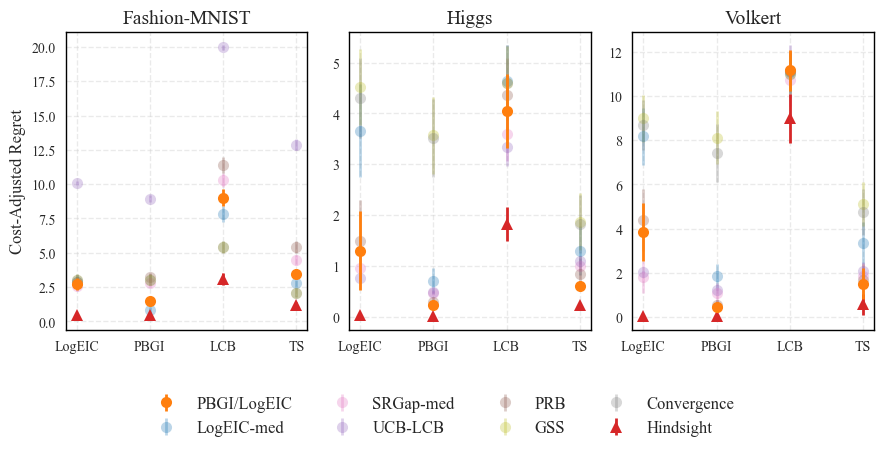

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil

# Set style
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.alpha': 0.4})
# plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-bright')
# plt.rcParams['axes.facecolor'] = (234/255, 234/255, 242/255, 0.3)  # 0.3 = 30% opaque
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

def style_spines(ax, color='black', linewidth=1):
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor(color)
        spine.set_linewidth(linewidth)

# Config
dataset_names = ['Fashion-MNIST', 'higgs', 'volkert']
lam = 1e-4
lam_str = '1e-4'
acq_order = ['LogEIC', 'PBGI', 'LCB', 'TS']
init = 20
n_cols = len(acq_order)

# Set up plot
fig, axes = plt.subplots(1, len(dataset_names), figsize=(3 * len(dataset_names), 4 * 1), sharey=False)

for col, d in enumerate(dataset_names):
    ax = axes[col]
    best_acc = best_acc_per_dataset[d]
    best_error = 100. - best_acc

    for j, acq in enumerate(acq_order):
        fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq

        for rule in stopping_rules:
            if rule['acq_key'] != f"PBGI({lam_str})":
                continue

            stop_vals = []
            stop_iters = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                errs = metrics_per_acq[d][fixed_acq]["final test error"][seed]
                costs = metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed]
                if rule['is_hindsight']:
                    regs = np.array(errs) - best_error + lam * np.array(costs)
                    idx = np.argmin(regs)
                else:
                    idx = next((k for k in range(init, len(errs)) if rule['condition_fn'](k, seed, d)), len(errs) - 1)
                stop_vals.append((errs[idx] - best_error) + lam * costs[idx])

            mean_val = np.mean(stop_vals)
            err_val = np.std(stop_vals) / np.sqrt(len(stop_vals))

            alpha = 1.0 if (rule['stp_key'] == 'PBGI' or rule['is_hindsight']) else 0.3
            zorder = 3 if rule['stp_key'] == 'PBGI' else 2
            marker = "^" if rule['is_hindsight'] else rule['marker'] 
            ax.errorbar(j, mean_val, yerr=2 * err_val,
                        fmt=marker,
                        markersize=8,
                        linewidth=2,
                        color=rule['color'],
                        capsize=6,
                        alpha=alpha,
                        zorder=zorder,
                        label=rule['label'])

    ax.set_xticks(range(n_cols))
    ax.set_xticklabels(acq_order)
    if (d == "Fashion-MNIST"):
        ax.set_title(d)
    else:
        ax.set_title(d.capitalize())
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylabel("Cost-Adjusted Regret" if col == 0 else "")
    style_spines(ax)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
legend_hls = dict(zip(labels, handles))

fig.legend(legend_hls.values(), legend_hls.keys(),
           loc='lower center',
           bbox_to_anchor=(0.5, -0.2),
           ncol=ceil(len(legend_hls) / 2),
           fontsize=12)

# fig.suptitle(f"Cost-Adjusted Regret (λ = {str(lam)})", fontsize=20)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])
plt.savefig(f'../plots/BarPlot_empirical.pdf', bbox_inches='tight')
plt.show()